In [1]:
import numpy as np
import random

from lib.gramians import Make
from lib.plotting import plot_eig, plot_W

In [2]:
n_e = 160 # number of excitatory neurons
n_i = 40  # number of inhibitory neurons
n = n_e + n_i  # number of neurons
p = 0.2 # exc. connection density
radius = 1.2 # spectral radius
dc_eval = -10 # eigenvalue of DC mode
e = slice(0,None),slice(0,n_e) 
i = slice(0,None),slice(n_e,None) 

## Initialising the connectivity matrix

In [3]:
def normalise(W):
    W[i] = np.minimum(0, W[i])
    z = (dc_eval - np.sum(W, axis=1).reshape(-1,1)) / n_i
    W[i] = np.minimum(0, z + W[i])
    W = W - np.diag(np.diag(W))
    #np.fill_diagonal(W, 0)
    return W

In [4]:
def initialise(n, p, radius):
    w0 = radius / np.sqrt(p * (1-p) * n) 
    # initialise connectivity matrix with the right density
    W = np.random.lognormal(np.log(w0),0.5,size=[n,n])
    #build adjacency matrix of connections
    adjacency = np.random.uniform(0,1,size=[n,n_e])
    adjacency[adjacency>p] = 2
    adjacency[adjacency<=p] = 1
    adjacency[adjacency>1] = 0
    W[e] = W[e] * adjacency # remove silence percent of the synapses
    W[i] = -np.random.rand(n,n_i)
    W = W - np.diag(np.diag(W)) # remove self connections 
    W = normalise(W)
    return W

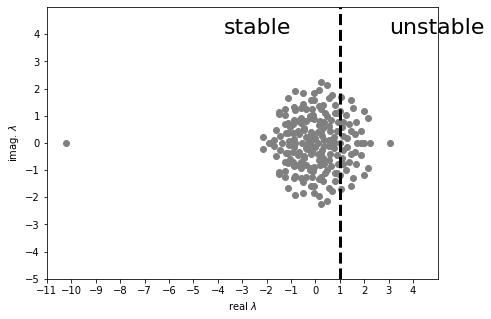

In [5]:
np.random.seed(5) 
W = initialise(n, p, radius)
plot_eig(W)

## Optimize

In [8]:
def soc_function(W, eta, threshold):
    for step in range(n_iter):
        s = np.max(np.linalg.eig(W)[0].real)
        if s < threshold: 
            print("FINAL spectral abscissa  %f" % s)            
            plot_eig(W)
            break            
        eta = min(max(0.5 * eta if s > s_ else 1.01 * eta,1),8) if step > 0 else 1
        s_ = s
        shift = max(1, 1.2*s)
        A = W - shift * np.eye(n)
        Q = Make(A,None).O.m # observability gramian
        P = Make(A,None).C.m
        QP = Q.dot(P)
        dW = QP / np.trace(QP) # gradient of smoothed spectral abscissa with respect to W
        W[i]  = W[i] - eta * dW[i]
        W = normalise(W)
        if (step % plot_every) == 0:
            plot_eig(W)
            print("step %3i | spectral abscissa  %f " % ((step,s)))
    return W

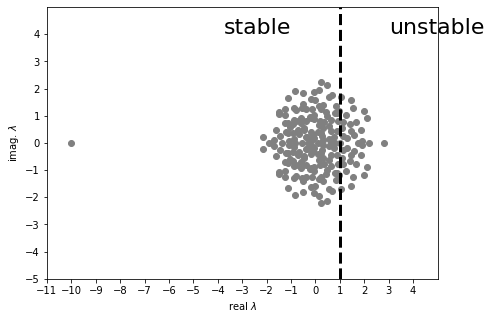

step   0 | spectral abscissa  3.066981 
FINAL spectral abscissa  0.799199


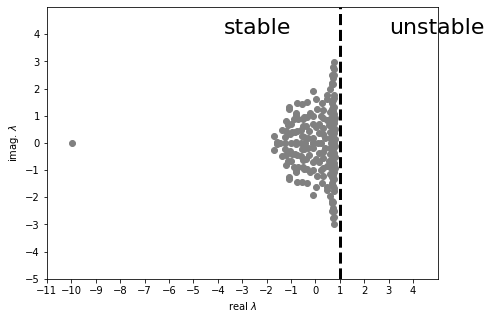

In [9]:
%matplotlib inline 
n_iter = 5001 # number of training steps
threshold = 0.8 # stop optimization when spectral abscissa lower than threshold 
plot_every = 600  # optimisation flags
rate=1 #learning rate

W=soc_function(W, rate, threshold)

In [ ]:
# Now let's save our inhibition stabilised network 
isn_name = 'isn.txt'
np.savetxt(isn_name,W)

In [ ]:
plot_W(W)